In [1]:
"""Run experiments as reported in the paper."""
import os
import sys
from itertools import product

sys.path.append(os.path.realpath("."))
root_path = os.path.join(os.path.expanduser('~'), 'sequential-auction-on-gpu')
if root_path not in sys.path:
    sys.path.append(root_path)

from time import perf_counter as timer
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps
colors = colormaps['tab20b'].colors

import src.utils.io_utils as io_ut
from src.learners.multi_agent_learner import MultiAgentCoordinator
from src.utils.coordinator_utils import get_env

def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

/home/kohring/sequential-auction-on-gpu/sequential-auctions-on-gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 4
runs = 3
policy_sharing = True

num_rounds_to_play_options = [2]
num_simulations_options = [2**7, 2**9, 2**11, 2**13, 2**15, 2**17, 2**19, 2**21]
action_discretization_options = [128, 64, 32, 16]

In [3]:
utility_losses = np.zeros((
    runs,
    len(num_rounds_to_play_options),
    len(num_simulations_options),
    len(action_discretization_options)
))
elapsed_times = np.zeros_like(utility_losses)

options = enumerated_product(
    num_rounds_to_play_options,
    num_simulations_options,
    action_discretization_options,
)
for idx, option in options:
    num_rounds_to_play, num_simulations, action_discretization = option

    for i in range(runs):
        config = io_ut.get_config(
                overrides=[
                f"seed={i}",
                f"device={device}",
                f"policy_sharing={policy_sharing}",
                f"verify_br=true",
                f"verifier.num_simulations={num_simulations}",
                f"verifier.action_discretization={action_discretization}",
                f"rl_envs.num_rounds_to_play={num_rounds_to_play}",
                f"rl_envs.num_agents={num_rounds_to_play + 1}",
                f"delete_logs_after_training=true",
            ]
        )
        env = get_env(config)
        ma_learner = MultiAgentCoordinator(config, env)

        tic = timer()
        utility_losses_for_all_agents = ma_learner.verify_in_BNE().values()
        elapsed_time = timer() - tic

        utility_losses[(i,) + idx] = np.mean(list(utility_losses_for_all_agents))
        elapsed_times[(i,) + idx] = elapsed_time

        # Wrap up
        io_ut.wrap_up_learning_logging(config)

In [27]:
def plot(metric, time):
    markers = ['o', '^', 's', 'p', '.', '+'] * 3
    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot([num_simulations_options[0], num_simulations_options[-1]], [0, 0], '--', color='black')
    for ax, y in zip(axs, [metric, time]):
        for j, num_simulations in enumerate(action_discretization_options):
            mean, std = y[:, :, j].mean(axis=0), y[:, :, j].std(axis=0)
            ax.plot(num_simulations_options, mean,
                    label=f'{num_simulations}',
                    ms=7, color=colors[j], marker=markers[j])
            ax.fill_between(num_simulations_options, mean-std, mean+std, alpha=.4,
                            color=colors[j])
        ax.set_xlabel('number of simulations')
        ax.grid(linestyle='--'); ax.set_xscale('log', base=2)
    # axs[0].set_yscale('log', base=10)
    axs[0].set_ylim([-.005, 0.02])
    axs[1].set_yscale('log', base=2)
    axs[0].legend(title="discretization")
    return axs

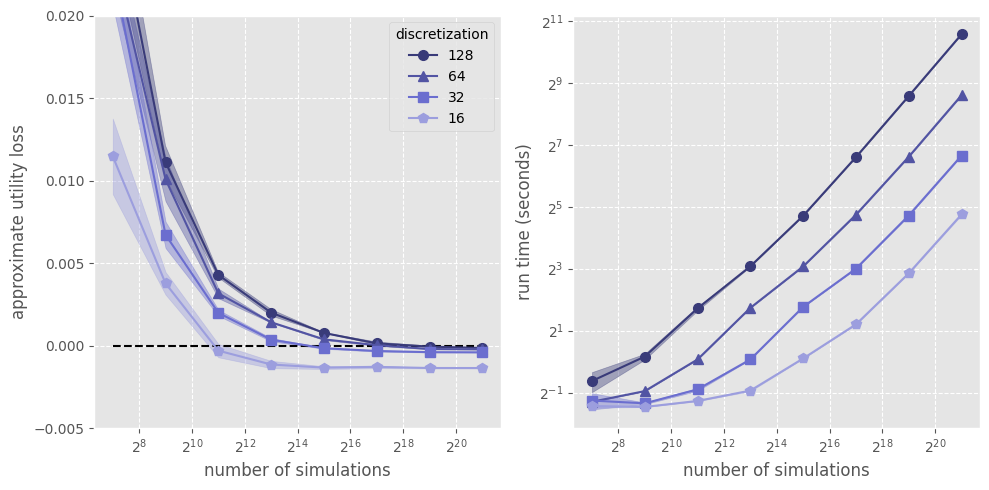

In [30]:
for j, num_rounds_to_play in enumerate(num_rounds_to_play_options):
    axs = plot(utility_losses[:, j, :, :], elapsed_times[:, j, :, :])
    # plt.suptitle(f"Sequential sales: {num_rounds_to_play} stages")
    axs[0].set_ylabel('approximate utility loss')
    axs[1].set_ylabel('run time (seconds)')
    plt.tight_layout(); plt.savefig(f'../logs/utility_loss_analysis_{num_rounds_to_play}_stages.pdf')
    plt.show()